In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import GridSearchCV

prng = np.random.RandomState(20250310)

%precision 3
pd.set_option('display.precision', 3)

# Illustrating bias-variance trade-off: Univariate vs multivariate model

## Our problem

Let"s start with a simple linear model:

$$
Y = f(X) + \varepsilon = \beta_1 X_1 + \beta_2 X_2 + \varepsilon
$$

The true model is:

$$
f(X) = X_1 + X_2
$$

In [2]:
def trueModel(x1, x2):
    y = x1 + x2
    return y

def generateData(prng, sample_size):
    features = [prng.uniform(0, 1, size=sample_size) for _ in range(3)]
    y_true = trueModel(features[0], features[1])
    y = y_true + prng.normal(0, 2, size=sample_size) # sigma(epsilon) = 2
 
    feature_df = pd.DataFrame({
        'x1': features[0],
        'x2': features[1]
    })

    return feature_df, y


In [3]:
# Evaluate the model's performance at a single point: X=0.5
test_data = pd.DataFrame({'x1': [0], 'x2': [0]})
trueModel(test_data['x1'], test_data['x2'])[0]

np.int64(0)

## Estimate two models: Linear Regression and Lasso

Lasso recap: optimize for the sum of squared residuals (like simple OLS) + a penalty term (= sum of the absolute values of the coefficients)

**TODO**:

- Extend the code below to estimate two models: a simple linear regression and a Lasso
- As we won't do any feature engineering here, there is no need for `Pipeline`
- For Lasso, use the default penalty parameter but control the random state with our pseudo-random number generator (`prng`)
- Get predictions for the (0, 0) point for both models (you can use the `test_data`)

In [4]:
sample_size = 20

X, y = generateData(prng, sample_size)

lm = LinearRegression().fit(X, y)
lasso = Lasso(random_state=prng).fit(X, y)

# TBA

print("Linear model prediction: ", lm.predict(test_data)[0])
print("Lasso prediction: ", lasso.predict(test_data)[0])

Linear model prediction:  0.6728063865663029
Lasso prediction:  1.2875239860708245


In [5]:
lasso.coef_

array([-0.,  0.])

In [6]:
?Lasso

Init signature:
Lasso(
    alpha=1.0,
    *,
    fit_intercept=True,
    precompute=False,
    copy_X=True,
    max_iter=1000,
    tol=0.0001,
    warm_start=False,
    positive=False,
    random_state=None,
    selection='cyclic',
)
Docstring:     
Linear Model trained with L1 prior as regularizer (aka the Lasso).

The optimization objective for Lasso is::

    (1 / (2 * n_samples)) * ||y - Xw||^2_2 + alpha * ||w||_1

Technically the Lasso model is optimizing the same objective function as
the Elastic Net with ``l1_ratio=1.0`` (no L2 penalty).

Read more in the :ref:`User Guide <lasso>`.

Parameters
----------
alpha : float, default=1.0
    Constant that multiplies the L1 term, controlling regularization
    strength. `alpha` must be a non-negative float i.e. in `[0, inf)`.

    When `alpha = 0`, the objective is equivalent to ordinary least
    squares, solved by the :class:`LinearRegression` object. For numerical
    reasons, using `alpha = 0` with the `Lasso` object is not advised.

## Monte Carlo simulation

**TODO**:

- Extend the code below to run a Monte Carlo simulation
- For each realization of data, we estimate 1+20 models: a simple linear regression and 20 different Lasso models with various penalty parameters (collected in `alphas_to_try`)

In [7]:
# Monte Carlo simulation

n_iterations = 1000
alphas_to_try = np.linspace(0.01, 0.5, num=20)

lm_predictions = np.empty(n_iterations)
lasso_predictions = np.empty((n_iterations, len(alphas_to_try)))
lasso_n_coeffs = np.empty((n_iterations, len(alphas_to_try)))

# Perform the Monte Carlo simulation
for i in range(n_iterations):

    X, y = generateData(prng, sample_size)

    lm_model = lm.fit(X, y)
    lm_predictions[i] = lm_model.predict(test_data)[0]

    for ida, a in enumerate(alphas_to_try):
        lasso_model = Lasso(alpha=a, random_state=prng).fit(X, y)
        lasso_predictions[i, ida] = lasso_model.predict(test_data)[0]
        lasso_n_coeffs[i, ida] = np.count_nonzero(lasso_model.coef_)  # we would like to count the non-zero coefficients

Linear Regression could be interpreted as a special case of Lasso with alpha = 0. Let's concatenate the predictions of the two models. (*Note that `lm_predictions` is a 1D array so first we need to reshape it to a 2D array with `reshape(-1, 1)`.*)

In [8]:
predictions = np.concatenate([lm_predictions.reshape(-1, 1), lasso_predictions], axis=1)
predictions.shape

(1000, 21)

In [9]:
alphas = np.concatenate([[0], alphas_to_try])
biases = np.mean(predictions - trueModel(test_data['x1'], test_data['x2'])[0], axis=0)
variances = np.var(predictions, axis=0)
mses = np.mean(np.square(predictions - trueModel(test_data['x1'], test_data['x2'])[0]), axis=0)

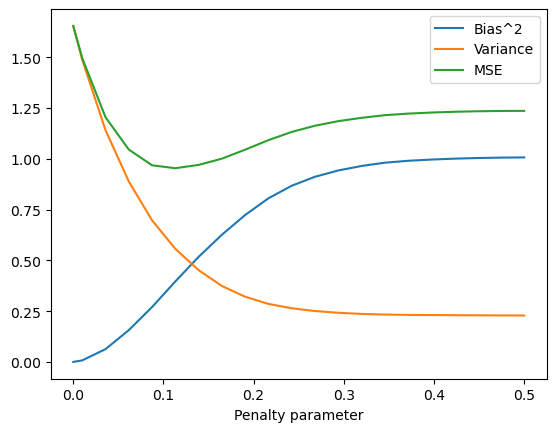

In [10]:
plt.plot(alphas, biases**2, label='Bias^2')
plt.plot(alphas, variances, label='Variance')
plt.plot(alphas, mses, label='MSE')
plt.xlabel('Penalty parameter')
plt.legend()
plt.show()

Penalized regression performs better than the true (unpenalized) model!

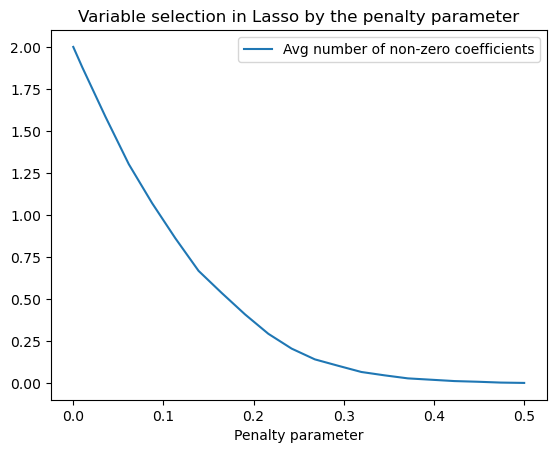

In [11]:
avg_num_coeffs = np.concatenate([[2], np.mean(lasso_n_coeffs, axis=0)])
plt.plot(alphas, avg_num_coeffs, label='Avg number of non-zero coefficients')
plt.xlabel('Penalty parameter')
plt.title('Variable selection in Lasso by the penalty parameter')
plt.legend()
plt.show()

## Finding the best penalty parameter with cross-validation (hyperparameter tuning)

**TODO**:

- Extend the code below to run a grid search over the alpha values using `GridSearchCV()` (~ repeat the same exerice as we did above but with cross-validation on the same dataset, )

In [12]:
?GridSearchCV

Init signature:
GridSearchCV(
    estimator,
    param_grid,
    *,
    scoring=None,
    n_jobs=None,
    refit=True,
    cv=None,
    verbose=0,
    pre_dispatch='2*n_jobs',
    error_score=nan,
    return_train_score=False,
)
Docstring:     
Exhaustive search over specified parameter values for an estimator.

Important members are fit, predict.

GridSearchCV implements a "fit" and a "score" method.
It also implements "score_samples", "predict", "predict_proba",
"decision_function", "transform" and "inverse_transform" if they are
implemented in the estimator used.

The parameters of the estimator used to apply these methods are optimized
by cross-validated grid-search over a parameter grid.

Read more in the :ref:`User Guide <grid_search>`.

Parameters
----------
estimator : estimator object
    This is assumed to implement the scikit-learn estimator interface.
    Either estimator needs to provide a ``score`` function,
    or ``scoring`` must be passed.

param_grid : dict or list of

In [ ]:
X, y = generateData(prng, sample_size)
lasso_model = Lasso()
lasso_cv = GridSearchCV(lasso_model, {"alpha": alphas_to_try}, scoring="neg_mean_squared_error")  # run with the default 5 folds
lasso_cv.fit(X, y)

GridSearchCV(estimator=Lasso(),
             param_grid={'alpha': array([0.01 , 0.036, 0.062, 0.087, 0.113, 0.139, 0.165, 0.191, 0.216,
       0.242, 0.268, 0.294, 0.319, 0.345, 0.371, 0.397, 0.423, 0.448,
       0.474, 0.5  ])},
             scoring='neg_mean_squared_error')

In [14]:
lasso_cv.best_params_

{'alpha': 0.216}

In [15]:
lasso_cv.predict(X)

array([1.19, 1.19, 1.19, 1.19, 1.19, 1.19, 1.19, 1.19, 1.19, 1.19, 1.19,
       1.19, 1.19, 1.19, 1.19, 1.19, 1.19, 1.19, 1.19, 1.19])

In [16]:
print(f"Coefficients of the best model: beta_1={lasso_cv.best_estimator_.coef_[0]}, beta_2={lasso_cv.best_estimator_.coef_[1]}")
print(f"Intercept of the best model: {lasso_cv.best_estimator_.intercept_:.3f}")


Coefficients of the best model: beta_1=-0.0, beta_2=0.0
Intercept of the best model: 1.190


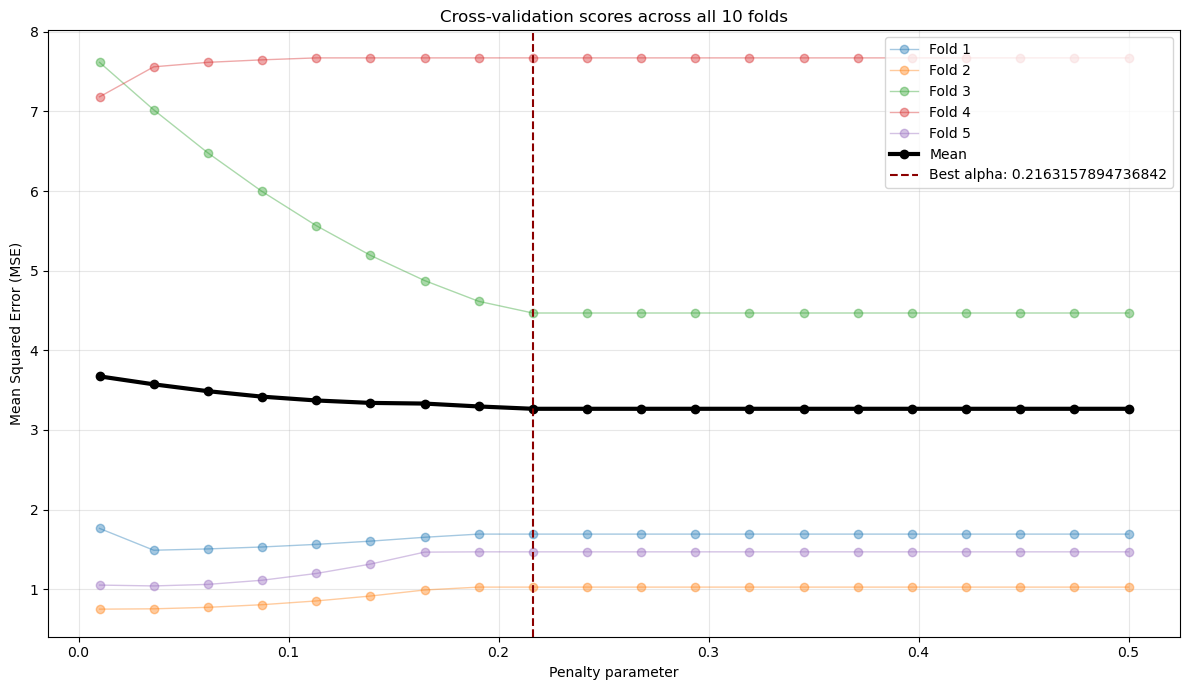

In [18]:
# Extract alpha values and scores for all 5 folds
alphas = lasso_cv.cv_results_['param_alpha'].data
mean_scores = -lasso_cv.cv_results_['mean_test_score']

plt.figure(figsize=(12, 7))

# Plot individual fold scores
for i in range(5):  # For all 5 folds
    fold_key = f'split{i}_test_score'
    fold_scores = -lasso_cv.cv_results_[fold_key]  # Negate to get MSE
    plt.plot(alphas, fold_scores, 'o-', alpha=0.4, linewidth=1, label=f'Fold {i+1}')

# Plot the mean score with heavier line
plt.plot(alphas, mean_scores, 'o-', linewidth=3, color='black', label='Mean')

# Mark the best alpha
best_alpha = lasso_cv.best_params_['alpha']
plt.axvline(x=best_alpha, color='darkred', linestyle='--', label=f'Best alpha: {best_alpha}')

plt.xlabel("Penalty parameter")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("Cross-validation scores across all 10 folds")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Here we can only cook from the given data (n=20). In the previous example, we repeated the experiment 1000 times, allowing us to measure the average performance of the models across many possible datasets (so we basically cooked from 1000x20 data points). In contrast, cross-validation works with only the single available dataset, which better reflects the real life situation where we must estimate performance using only the data at hand.